# Classwork Example for 09 17 2020



In this directory, I have included a FITS data file containing a 1D spectrum of absorption detected toward a cloud at the center of the Milky Way.
You can read these data into python using the astropy package. 



I have displayed the spectrum below (zooming in on the [OI] $^3P_2 -\; ^3P_1$ line at 63.2 $\mu$m).

(1) Calculate the equivalent width of this line (both in terms of wavelength $W_\lambda$ and the dimensionless equivalent width $W$ from Draine.

(2) Determine degeneracy of the upper and lower levels of this transition (Reference: Draine 4.5.1)

(3) Use this and the Einstein A ( $A_{ul} = 8.46\times10^{-5}$ ) to calculate $f_{ul}$ for this transition. 

(4) Calculate the column density, assuming the line to be optically thin, using equation 9.15 from Draine. Compare this to the value of the column density that was computed in the literature for this data set: $3.1\times10^{19}$ cm$^{-2}$ (Vastel et al. 2002; https://iopscience.iop.org/article/10.1086/344136/pdf)





In [2]:
import numpy as np                          # I use this for maths and sometimes arrays.
                                            # "np" is just an abbreviation since we call this package so often!
import pylab                                # I use this for arrays and plotting sometimes
import matplotlib
import matplotlib.pyplot as plt                    # Standard plotting package
import scipy

from astropy import units as u              # This one helps with unit conversion



                                            # Super important!! 
                                            # This embeds plots in the Jupyter window 
                                            # (instead of showing them as pop-ups)
%matplotlib inline                             

plt.rc('font', family='sans-serif')  # Set plot fonts
plt.rc('text', usetex=True)      
#plt.rc('text', usetex=False)        # This is a quick fix if you don't have latex on your computer



## Solution:

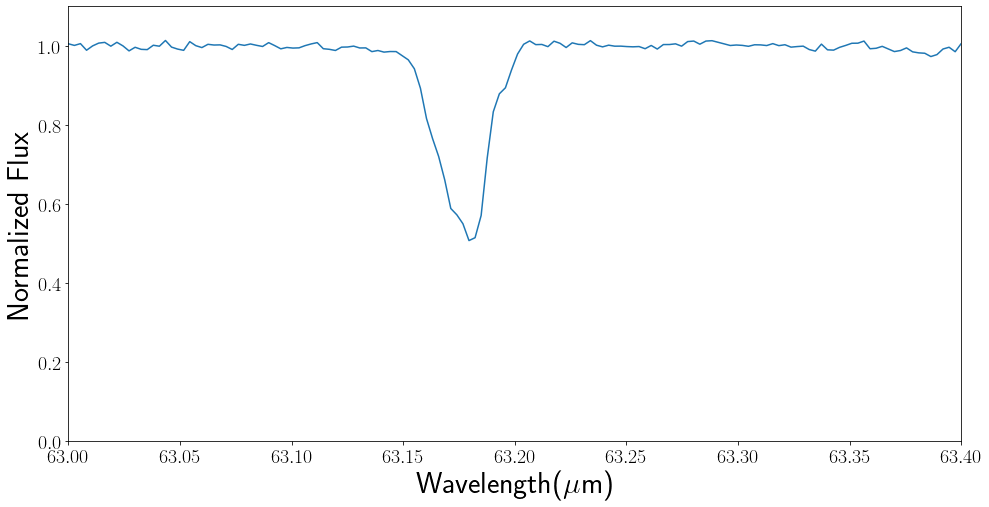

In [3]:
import astropy.io.fits as fits              # I use this to import FITS images. 
                                            # Astropy should be included in your conda installation


fits_table = 'B2_Full.fits'
hdul = fits.open(fits_table)    # open a FITS file
data = hdul[1].data             # assume the first extension is a table
wavelength = data.field(0)      # grab column 1
norm_flux = data.field(1)       # grab column 2
                                
                                # Wavelength units: microns
                                # Flux units: Watts per cm^2 per micron 
                                # (if data were not normalized; actually, y values are unitless)

plt.figure(0,figsize=(16,8))
ax = plt.subplot()
plt.plot(wavelength,norm_flux)
plt.xlim(63,63.4) # Set the limits of wavelength to look at
plt.ylim(0,1.1)   # Note that this is a normalized flux, sometimes called "line-to-continuum ratio"
plt.xlabel("Wavelength($\mu$m)",fontsize=30)
plt.ylabel("Normalized Flux",fontsize=30)
ax.tick_params(axis = 'both', which = 'major', labelsize = 20) 



In [4]:
# Start by calculating the Equivalent Width

# Grab a small chunk of the spectrum around the line
line = pylab.where((wavelength<63.4)*(wavelength>63))
waves = wavelength[line]
fluxs = norm_flux[line]

# Here I am being lazy and estimating the line center as the minimum;
# This is basically correct but there is probably a small velocity shift (80 km/s = ~0.03% or 0.016 microns)
center = pylab.where(fluxs==np.min(fluxs))

print('Central Wavelength: %1.2f microns'%waves[center])


# Here I quickly figure out the channel width. 
delta_wave = waves[1]-waves[0] # microns per channel

# Note that this is changing (slightly) with wavelength,
# so a slightly more robust way is commented out here below
# dlambda = np.diff(waves).mean() 

# Here I sum (e.g., integrate over) the total expected continuum flux in this interval, e.g., 
# Flux = 1 in every channel
expect = (delta_wave)*np.size(fluxs)

# Here I integrate over the actual signal
actual= (delta_wave)*np.sum(fluxs)

D_EQW = (expect-actual)
# The difference between these two is the dimensionless equivalent width
print('Dimensionless Equivalent Width: %1.3f'%D_EQW)

# We can divide by the central wavelength to get the Equivalent width in terms of lambda
EQW = D_EQW/waves[center]
print('Equivalent Width: %1.4f microns' %EQW)

Central Wavelength: 63.18 microns
Dimensionless Equivalent Width: 0.013
Equivalent Width: 0.0002 microns


In [5]:
# Now we want to determine the degeneracy of the upper and lower states. 

# Note that the terms have the same multiplicity: Both are 3P, so have S=1 and L=1
# The multiplicity for both is (2S+1) * (2L + 1) = 9

# Degeneracy for these fine-structure levels is given by g = 2J+1

# The upper state has a term of 3P2, so J=2
g_up = (2*2+1)

# The lower state has a term of 3P1, so J=1
g_low =(2*1 + 1)

In [6]:
# Now we have what we need to determine the oscillator strength!

c = 2.998e8 *u.m /u.s
lambda_0 = waves[center]* 1e-6 * u.m
nu = c / lambda_0
A_ul = 8.46e-5 /u.s
m_e = 9.1e-31 * u.kg
e = 4.8e-10 *u.dyn**0.5 * u.cm  # NOTE: I give this value in cgs units of Statcoulombs! 
                                # If you stay in SI you have to add in an epsilon_0 or something horrible!

#Using the left-hand part of the expression of Draine, Equation 6.20: 
flu_test = g_up / g_low * m_e * c**3 / 8 / np.pi**2 / e**2 / nu**2 * A_ul
print("Oscillator Strength, Equation 1:", flu_test.si)

#Just for "fun" (e.g., when I forgot about statcoulombs and was getting a terrible answer) I also try the RHS of 6.20
flu = g_up/g_low * (lambda_0)**2 / 0.667 / u.cm**2 *u.s * A_ul

print("Oscillator Strength, Equation 2:",flu.si)

# Praise everything, both answers are dimensionless and the same, so we take the win!

Oscillator Strength, Equation 1: [8.440567e-09]
Oscillator Strength, Equation 2: [8.438106e-09]


In [8]:
# Column Density 

N_l = 1.30e12 /u.cm * D_EQW / flu / lambda_0

print("Column Density of [OI] 63 micron line: ",N_l.cgs)

# This is 10x larger than the literature value but hey, I'll take it!
# The paper was a little more careful about fitting different velocity components 
# and may have assigned some of the absorption to (unrelated) foreground absorption
# rather than absorption local to the source.

Column Density of [OI] 63 micron line:  [3.2396496e+20] 1 / cm2


# Absorption Spectra in the News!

The big news this week was the detection of Phosphine (PH$_3$) in the atmosphere of Venus. 
You can read the Nature Astronomy paper here: https://www.nature.com/articles/s41550-020-1174-4

A lot of excitement was about finding an amount of PH$_3$ that is more than can be explained with curent chemical models (which admitted are limited! We don't actually know that much about Venus!)

The measurements you just did for [OI] basically outline what was done in this paper: to measure the amount of PH$_3$ from this spectrum you must turn the equivalent width into a column density. That column density can then be compared to the column density of everything else around it in the atmosphere of Venus to give an abundance (note that the abundance stated in the paper of 20 ppb is given in terms of 'parts per billion')

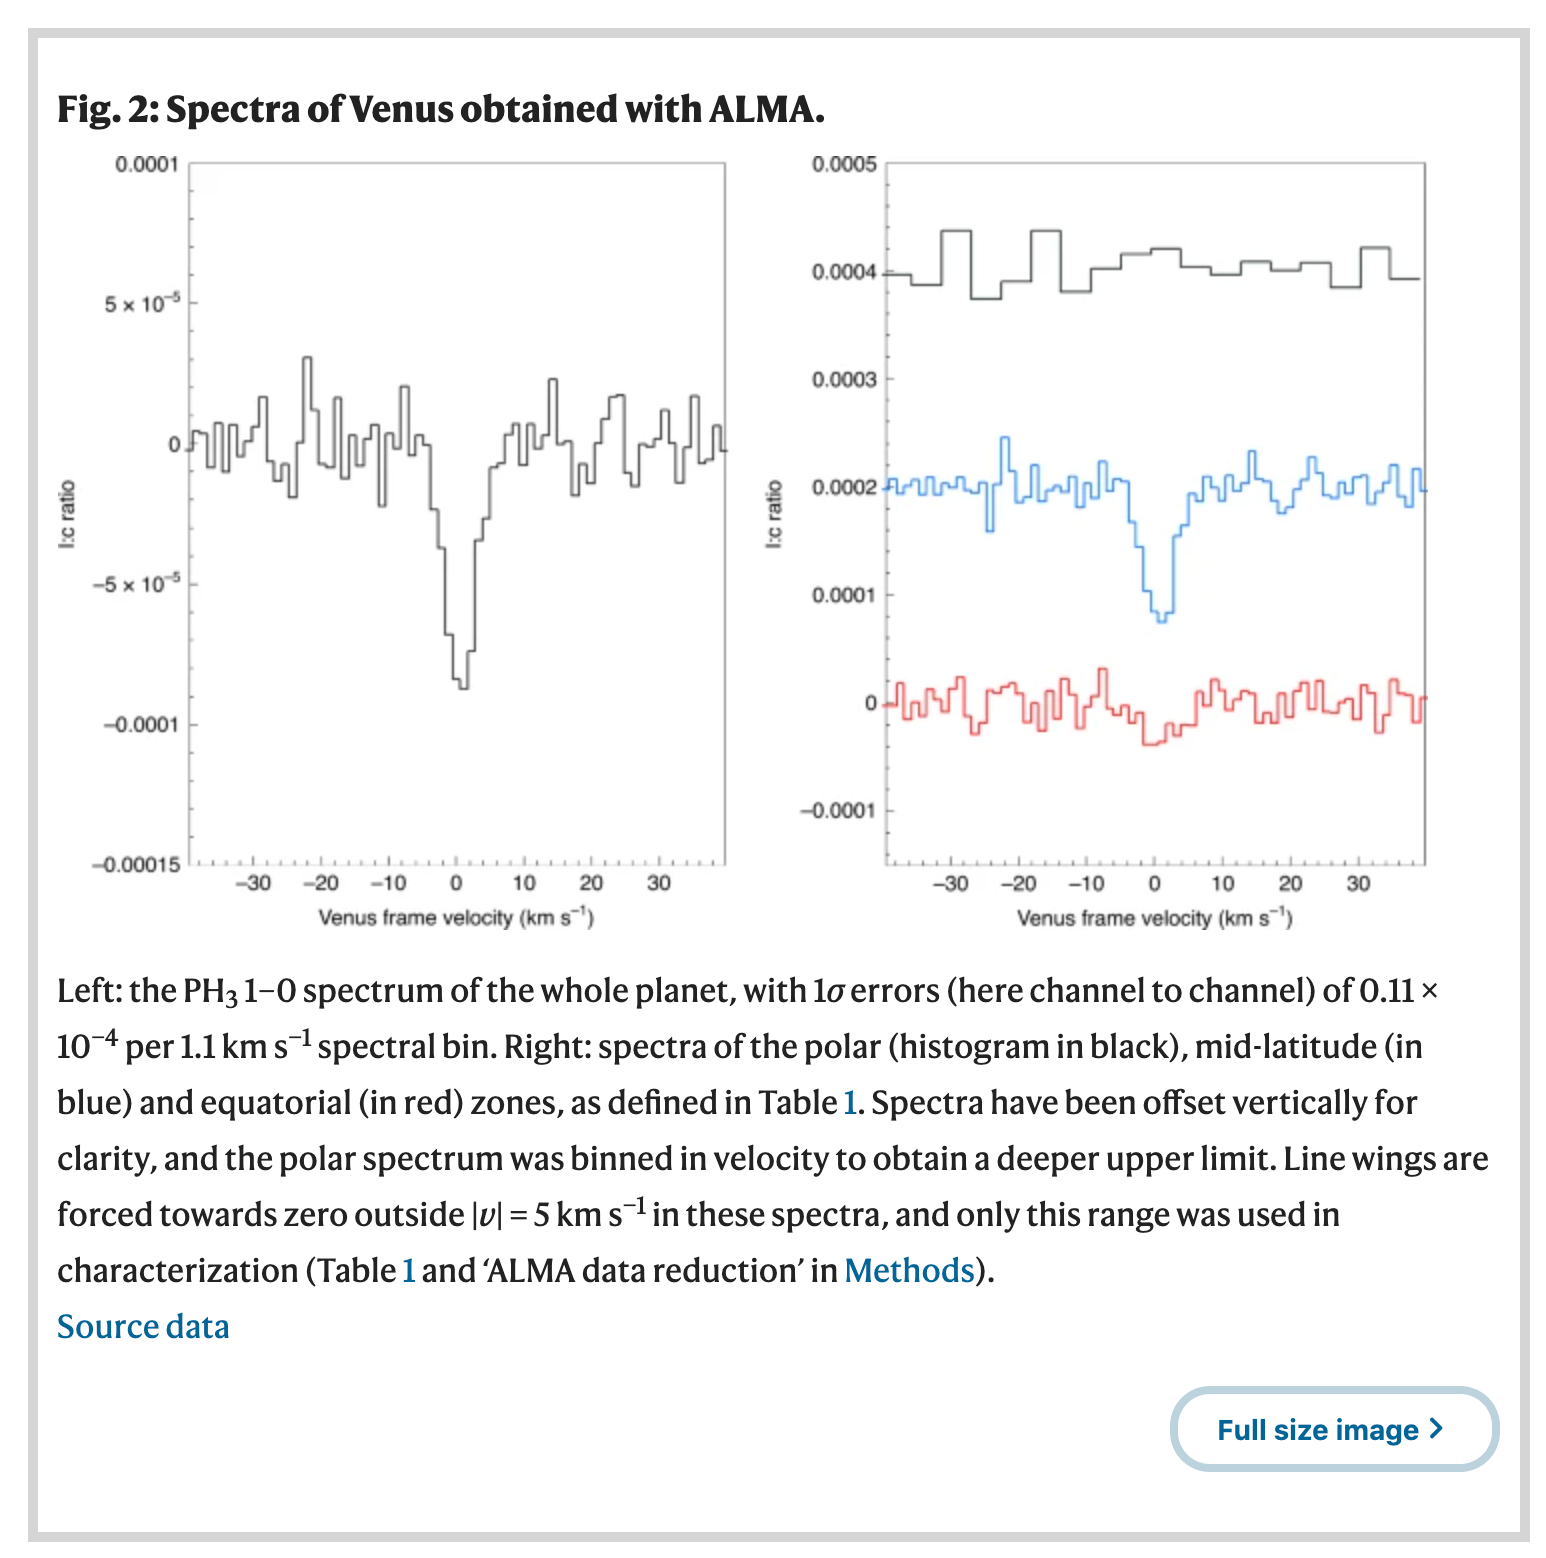

